## cnn_title_abs

In [1]:
# import packages
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import backend as K
import keras
import keras_metrics
import tensorflow as tf    
from tensorflow import keras 
import keras_metrics as km

In [2]:
# load the package
final_df = pd.read_csv('/project/train_data.csv')

In [3]:
final_df.head()

,Unnamed: 0,abstract.text_sw,biblio.invention_title.text_sw,claims.claims_sw,yo2
0,98980,disclosure relates hand control input device c...,unknown,a hand control input device comprising a ...,0
1,69824,one aspect present invention directed plant pl...,bacterial spore compositions for industrial uses,a plant or plant part coated with a composi...,1
2,9928,demonstrative embodiments include apparatuses ...,apparatus system and method of setting up an ...,a product comprising one or more tangible c...,0
3,75599,wavelength multiplexing apparatus includes div...,wavelength multiplexing apparatus and method,a wavelength multiplexing apparatus compris...,0
4,95621,first second inputs received first input indic...,method and apparatus for transmitter optimizat...,canceled a system comprising one ...,0


In [4]:
final_df.shape

(75000, 5)

In [5]:
# split train and test
y = final_df['yo2']
X = final_df.drop(columns = 'yo2')
X['tac'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['title_abs'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] 
X['title_claims'] = X['biblio.invention_title.text_sw'] + ' ' + X['claims.claims_sw']
X['abs_claims'] = X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['abstract'] = X['abstract.text_sw']
X['title'] = X['biblio.invention_title.text_sw']
X['claims'] = X['claims.claims_sw']

In [6]:
trainX, testX, trainy, testy = train_test_split(X['title_abs'], y, test_size=0.25, random_state = 42)

In [7]:
trainX.shape,trainy.shape,testX.shape,testy.shape

((56250,), (56250,), (18750,), (18750,))

In [8]:
from pickle import dump

def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
save_dataset([trainX,trainy], 'train_title_abs.pkl') 

Saved: train_title_abs.pkl


In [9]:
import csv
import pydot
filename = 'train_title_abs.pkl'

In [10]:
# load a clean dataset
def load_dataset(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(500, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(),
                                                                         tf.keras.metrics.Recall(),
                                                                        tf.keras.metrics.AUC(curve='ROC')])
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel_title_abs.png')
    return model

# load training dataset
trainLines, trainLabels = load_dataset(filename)

# create tokenizer
tokenizer = create_tokenizer(trainLines)

# calculate max document length
length = max_length(trainLines)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trains_X = encode_text(tokenizer, trainLines, length)
print(trains_X.shape)

# define model
model = define_model(length, vocab_size)

class_weights = 1/(trainLabels.value_counts()/len(trainLabels))
class_weights = {0: class_weights[0], 1: class_weights[1]}



Max document length: 512
Vocabulary size: 44972
(56250, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 512, 100)     4497200     input_1[0][0]                    
_________________________________

In [16]:
# fit model
history = model.fit([trains_X,trains_X,trains_X], array(trainLabels), epochs=16, batch_size=16, class_weight=class_weights)

Epoch 1/16
3516/3516 [==============================] - 1148s 326ms/step - loss: 0.2116 - precision: 0.7956 - recall: 0.9709 - auc: 0.9916
Epoch 2/16
3516/3516 [==============================] - 1128s 321ms/step - loss: 0.1971 - precision: 0.8046 - recall: 0.9730 - auc: 0.9929
Epoch 5/16
3516/3516 [==============================] - 1138s 324ms/step - loss: 0.1773 - precision: 0.8157 - recall: 0.9747 - auc: 0.9940
Epoch 6/16
3516/3516 [==============================] - 1140s 324ms/step - loss: 0.1634 - precision: 0.8214 - recall: 0.9738 - auc: 0.9941
Epoch 7/16
3516/3516 [==============================] - 1129s 321ms/step - loss: 0.1449 - precision: 0.8441 - recall: 0.9791 - auc: 0.9953
Epoch 8/16
3516/3516 [==============================] - 1138s 324ms/step - loss: 0.1481 - precision: 0.8433 - recall: 0.9783 - auc: 0.9945
Epoch 9/16
3516/3516 [==============================] - 1146s 326ms/step - loss: 0.1575 - precision: 0.8366 - recall: 0.9793 - auc: 0.9950
Epoch 10/16
3516/3516 [====

In [17]:
# save the model
model.save('model_title_abs.h5')

In [22]:
import pickle
with open('model_title_abs_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [18]:
#list all data in history
print(history.history.keys())

dict_keys(['loss', 'precision', 'recall', 'auc'])


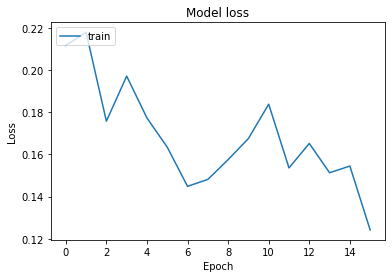

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history_title_abs.history_title_abs['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

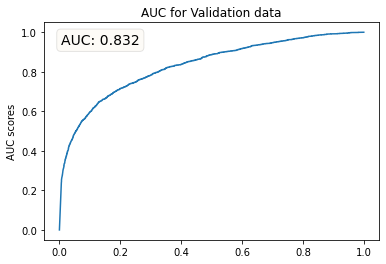

In [80]:
# roc curve
from sklearn.metrics import roc_curve, auc

#testX = encode_text(tokenizer, testX, length)

y_pred = model.predict([testX,testX,testX]).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(testy, y_pred);
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

fig, ax = plt.subplots()
textstr = 'AUC: %0.3f' % auc_keras

ax.plot(nn_fpr_keras, nn_tpr_keras)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('AUC for Validation data')
# plt.xlabel('xlabel')
plt.ylabel('AUC scores')

#plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras);
plt.show();

In [71]:
# load saved model
with open('/project/cnn/model_title_abs_history', 'rb') as f:
    history = pickle.load(f)

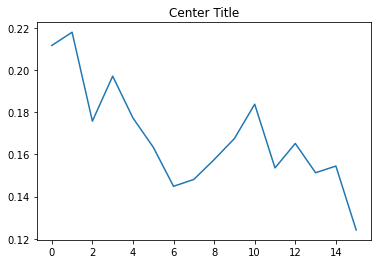

In [77]:
# Loss per Epoch
plt.plot(history['loss'])
plt.title('Loss per Epoch')
# plt.xlabel('xlabel')
# plt.ylabel('ylabel')
plt.show();

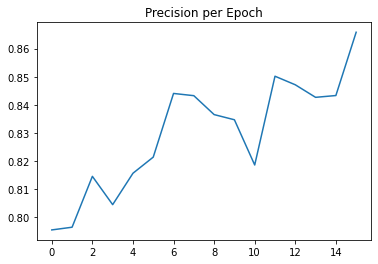

In [78]:
# Precision per Epoch
plt.plot(history['precision']);
plt.title('Precision per Epoch')
plt.show();